## Question 1: Hashing task!

In [ ]:
import numpy as np
from random import randint
from math import ceil
import random
# check if the number is prime 
def is_prime(num):
    for x in range(2, int(ceil(num**0.5))+1):
        if not num % x:
            return False
    return True
# the function for searching the closest prime number 
def find_prime(num):
    offset = 1
    done = False
    result = []
    while True:
        if is_prime(num+offset):
            result.append(num+offset)
            done = True
        if done:
            break
        offset += 1
    return result

def create_seed(n):
    return randint(0, n) # n is a prime number which is close to m so i am taking by random the number from the interval (0,prime close to m and bigger then m)

def bytes_to_long(bytes):
    length = len(bytes) #  take the len of the bytes for this task it will be always 5
    if length < 8:
        extra = 8 - length
        bytes = b'\000' * extra + bytes # append at the begining zero-bytes till i get 8 bytes
    assert len(bytes) == 8 
    # the main step is here 
    # we take the first byte and shift him at the k*8 bits for the firts 3 bytes it will be 0 but from the 3 i will get some numbers and every next number will be bigger 
    # at the last iteration i will get the 64 bits number and then i will summ all numbers together 
    return sum((b << (k * 8) for k, b in enumerate(bytes))) 
""" 
    I found that hash function murmur3 is one of the most common for bloom filter 
    because it is quite fast and has the right propertise such as uniform dist of
    the output and also there is murmur3_64 which means that the output will alsays
    be a number of 64 bits and as I can unserstand 32 bits if not enough because 
    len(bin(m)) = 32 bits so (32bits)mod(32bits or even more then 32 bits) will not 
    cover all space of bit_array which size is m, so that is why i decided to use 64 bits
"""
def murmur64(data, seed):

    m = 0xc6a4a7935bd1e995 # some number to do the output more uniform
    r = 47 # the bit shift actually i decided that output have to be number of 64 bit so 64 - 47 = 17 bit shift

    MASK = 2 ** 64 - 1 # the maximum value of the output also will use for the XOR transformations
    
    # take the all word by the letter transform to the numbers (all letters has their special number from 0 to 255)
    # and then thanslate all numbers to the bytes
    data_as_bytes = bytearray([ord(i) for i in list(data)])
    
    
    # also i want to emphasize that all this operation i could do the the string but it would be much slower 
    h = seed ^ ((m * len(data_as_bytes)) & MASK) # take the seed and do Bitwise XOR with the (m * len(data_as_bytes) Bitwise AND
    # Bitwise XOR: for ex x = 101 = 5 and y = 110 = 5 then x^y = 011 = 11 = 3
    
    # I know that every password will be 20 symbols that is why i choose the step = 5
    for ll in range(0, len(data_as_bytes), 5): # the idea is simple take the 5 bytes and then convert them to the 8 bytes 
        k = bytes_to_long(data_as_bytes[ll:ll + 5]) # take the bytes and create from them 64 bits number
        # then there are sequence of XOR operation which i took from the stack overflow 
        k = (k * m) & MASK # multiplication and Bitwise AND
        k = k ^ ((k >> r) & MASK) # Bitwise XOR with the Bitwise right shift on 47 bites with Bitwise AND
        k = (k * m) & MASK # multiplication and Bitwise AND
        h = (h ^ k) # Bitwise XOR
        h = (h * m) & MASK # multiplication and Bitwise AND

    h = h ^ ((h >> r) & MASK) # Bitwise XOR with the Bitwise right shift on 47 bites with Bitwise AND
    h = (h * m) & MASK # multiplication and Bitwise AND
    h = h ^ ((h >> r) & MASK) # Bitwise XOR with the Bitwise right shift on 47 bites with Bitwise AND

    return h
#  add the emelent to the bit_array
""" 
    The input of the function is a single password
    the size of the bit_array and the seeds for the
    len(seeds) = k. The output is the list of indexes
    which i have to switch in bit array from 0 to 1
"""
def add_element(element,m,seeds):
    inx = [murmur64(element,seed) % m for seed in seeds] # i decided that it is more convinient to return the indexes of the bit_array where i need to switch 0 to 1
    return inx
"""
    The input is a bit_array and the list of indexes
    which i have to switch inside the bit_array from 0
    to 1. The output in the bit_array with the swithed
    bits
"""
def switch_bits(bit_array,array_indexes):
    for index in array_indexes:
        bit_array[index] = 1
    return bit_array
"""
    The size of the bit_array and the seeds for hash 
    function. Inside the function i open  the file 
    passwowd1.txt and add all elements to the 
    bit_array. The output of the function is the 
    array of all indexes after adding all passwords
    from the file. I decided that it is better to
    accumulate all indexes and then for one time switch
    all indexes inside the bit_array
"""
def add_all_elements(m,seeds):
    indexes = []
    with open("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/DATA/passwords1.txt","r") as f: # open the file
        line = f.readline # read the line
        cnt = 1 # count the numbers of line which was read
        while line: # the loop till the end of the document 
            indexes.extend(add_element(line,m,seeds)) # add password the output is the array of the indexes
            line = f.readline() # read the line
            cnt += 1 # count the numbers of line which was read
            if cnt % 10000000 == 0: 
                print("Done: ",cnt) # to control how many password was added
    return indexes # the output is the array with all indexes which i have to switch
"""
    The input is a bit_array,password, size of the bit_array
    and seeds for the hash functions. The output is the string 
    "Probably Duplicate" if all indexes are 1 and 
    "Not Duplicate" if at least one index is not equal to 1
"""
def check_element(bit_array, element, m, seeds):
    indexes = [murmur64(element,seed) % m for seed in seeds] # get the indexes for password
    if all(bit_array[index] for index in indexes): # check is all elements in the bit_array is equal 1
        return "Probably Duplicate"
    elif not all(bit_array[index] for index in indexes): # check is ar least one element in the bit_array not equal 1
        return "Not Duplicate"
"""
    The input is a bit_array,size of the bit_array and seeds
    fot the hash functions. This function is for cheking all
    password2.txt in the bit_array. The output is the number
    of duplicates
"""
def chek_all_passwords(bit_array, m, seeds):
    with open("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/DATA/passwords2.txt","r") as f:
        line = f.readline() # read the line
        cnt = 1 # count the numbers of line which was read
        Duplicate = 0 # create the variable for counting duplication
        while line: # the loop till the end of the document 
            if check_element(bit_array, line, m, seeds) == "Probably Duplicate":
                Duplicate += 1 # if for some password the output of all hash functions equal 1 it means that if is a duplicate
            line = f.readline() # read new password
            cnt += 1 # count the numbers of line which was read
            if cnt % 10000000 == 0:
                print("Done: ",cnt) # to control how many password was added
    return Duplicate # the numbet of duplicates 
            


In [22]:
# Now we need to understand which diapazon of numbers we want
# m - size of the filter
# p - tollerance
# n - number of elements inserted
n = 100000001 # i know that n = 100000001
p = 0.01 # suppose that i want to have 0.001 prob of collisions
m = int((-n*np.log(p))/(np.log(2)**2))
k = int((m/n)*np.log(2))
p = (1 - np.exp((-k*n)/m))**k

#### Formula to count the theoretical prob of collisions

In [23]:
p = (1 - np.exp((-k*n)/m))**k
print(p)

0.010143159173552936


#### Find the clossest prime number and create the bit_array with legth = m

In [24]:
prime = find_prime(m)[0]
bit_array = [0] * m

#### Create the seeds for the hash functions which i am going to uniformly from ( 0, m )

In [6]:
#create the rendom seed for hash functions
random.seed(123) # i always want the same seeds for my hash functions
seeds = [create_seed(prime - 1)  for i in range(k)]

In [9]:
import time

def BloomFilter(bit_array,m,seeds,k,p):
    start = time.time()
    
    all_indexes = add_all_elements(m,seeds)
    bit_array = switch_bits(bit_array,all_indexes)
    Duplicate = chek_all_passwords(bit_array, m, seeds)
    
    end = time.time()
    
    print('Number of hash function used: ', k)
    print('Number of duplicates detected: ', Duplicate)
    print('Probability of false positives: ', p)
    print('Execution time: ', end-start)
    
BloomFilter(bit_array,m,seeds,k,p)


Done:  10000000
Done:  20000000
Done:  30000000
Done:  40000000
Done:  50000000
Done:  60000000
Done:  70000000
Done:  80000000
Done:  90000000
Done:  100000000
Done:  10000000
Done:  20000000
Done:  30000000
Number of hash function used:  6
Number of duplicates detected:  14253460
Probability of false positives:  0.010143159173552936
Execution time:  12420.492629051208


In [45]:
print("Hours:",(12420.492629051208/3600))

Hours: 3.4501368414031135


## Bonus

In [20]:
passwords1 = []
passwords2 = []
with open("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/DATA/passwords1.txt","r") as f:
    while :
        passwords1.append(f.readline())

with open("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/DATA/passwords2.txt","r") as f:
    cnt = 0
    while :
        passwords2.append(f.readline())
        
set_passwords1 = set(passwords1)
set_passwords2 = set(passwords2)
print('The number of Duplicates',len(set_passwords1.intersection(set_passwords2)))
print("The exact numbet of False positive : ", (14253460 - len(set_passwords1.intersection(set_passwords2))))

The number of Duplicates 14000000
The exact numbet of False positive :  253460


Also as i have checked there is 14 millions of the duplicates. So thre was 253460 numbers of the collisions

Okey now a little bit math)) the length of the passwords2.txt is 40 millions of the passwords. 14 millions is the same as in the password1.txt. So unique passwords just 26 millions. 
\begin{array}{c}
UniqPas = 26000000\\\
NumDupl = 253460\\\
\end{array}
Count the 1 percent False Positive:
\begin{array}{c}
\frac{UniqPas}{100} = 260000 \\\
\end{array}
As we can see the performance of very close to the theoretical p

## Uniform distribution of the hash function

In [35]:
passwords1 = []
with open("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/DATA/passwords1.txt","r") as f:
    cnt = 0
    while cnt < 1000000 :
        passwords1.append(f.readline())
        cnt +=1

random.seed(123) # i want the same seeds for my hash functions
k = 1 # For one hash function
seeds = [create_seed(prime - 1)  for i in range(k)]

In [36]:
output = []
for password in passwords1:
    output.extend(add_element(password, m, seeds))

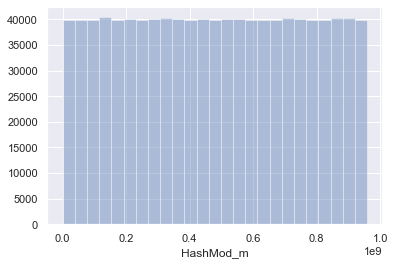

In [41]:
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)

df = pd.DataFrame(output,columns = ["HashMod_m"])

sns.distplot(df.HashMod_m,bins = 25,kde = False)

**As we can see the output of the hash function is uniformly distributed.**

## Question 2: Alphabetical Sort

In [18]:
#First question
def counting_sort(lst):
    # the auxiliary array
    auxlst=[0 for i in range(max(lst)+1)]

    # updating the values of the occurances for each value of the starting array...
    for i in lst:
        auxlst[i]=lst.count(i)
       # ...then i do the cumulative sum
    for i in range(1,len(auxlst)):
        auxlst[i]+=auxlst[i-1]
         
     #initialize the output
    sorted_array=[0 for i in range(len(lst))]
      
      # then update the values of the output putting each number in the right position
    for i in lst:
        sorted_array[auxlst[i]-1]=i
        auxlst[i]=auxlst[i]-1
          
    return sorted_array

In [19]:
#Second question
# Application to a list of letter
#In this case i have to sort a list that contains all the letters of the alphabet (not sorted) by using the counting-sort algorithm.
#Since the algo works with numbers i use the ascii code to do the task. Acording to the ascii code, each symbol (not only alphanumeric ones) is linked to a specific number. 
#For example the letter 'a' has 97. 
# I start taking all the letters of the alphabet...
alphabet=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
# ...then i shuffle them by using a simple numpy function\n",
import random
random.shuffle(alphabet)
def counting_sort_lett(lst):
    # I take a list which contains the ascii code for each letter.
    ascii_=[ord(i.lower()) for i in lst]
    sort_ascii=counting_sort(ascii_)
    return([chr(i) for i in sort_ascii])

In [20]:
#A function to sort a list of words if and only if there is no duplicate first letters (all the first characters are unique)
def countsort_difflett(lst):
    ascii_=[]
    sorted_words=[]
    # First of all i create a dictionary whose keys are the words and whose values are the first character of the word\n",
    first_letter={lst[i]:lst[i][0].lower() for i in range(len(lst))}
        
    # getting the array that contains di ascii code for every starting-letter\n",
    for i in range(len(lst)):
        ascii_.append(ord(lst[i][0]))
    pos_out=counting_sort_lett(first_letter.values())
    # In this case the array 'pos_out' gives me only the first letter of the word sorted, but i want the entire word. \n",
    # That's why i created the dictionary before.
    for i in pos_out:
        for k,j in first_letter.items():
            if i==j:
                sorted_words+=[k]
    return sorted_words

In [21]:
#A function to verify that there is no duplicate first letters (all the first characters are unique)
def condition_diff_lett(lst):
    boolean=False
    # In order to let the function works the strings have to be in lower case (in fact upper character has
    # a bigger ascii code than the lower ones) so...
    lst_low=[]
    for i in range(len(lst)):
        lst_low.append(lst[i].lower())
        
    word=[]
    # Before sorting the words i check if there are words which starts with the same letter...
    for i in range(len(lst)):
        for j in range(len(lst)):
            if lst_low[i][0]==lst_low[j][0] and lst_low[i]!=lst_low[j] and lst[j] not in word:
                word.append(lst[j])                
    
    if word==[]:
        boolean=True
    return(boolean)

#A function to output the index of the first character which is not the same in two words 
#For example: word1='word', word2='world', the output will be 3
def break_index(word1,word2):
    i=0
    while i<min(len(word1),len(word2)) and word1[i]==word2[i]:
        i+=1
    return(i) 

#The main function
def counting_sort_allwords(lst):
    if len(lst)<=1:
        return(lst)
    else:
    # Now i split the two cases: when there's no words with same first character and when there is words with same first character
        if condition_diff_lett(lst): # We test if we have only different first characters
            final_output=countsort_difflett(lst)
        else:
            # In order to let the function works the strings have to be in lower case (in fact upper character has
            # a bigger ascii code than the lower ones) so...
            lst_low=[]
            for i in range(len(lst)):
                lst_low.append(lst[i].lower())
        
            #We take the first word of the list as a reference to compare its first character 
            #to the first characters of the other words in the list
            reference=lst[0]
            refenrence_low= lst_low[0] 
            before = [] #At the end in this list we will have the words that are alphabetically before the refenrence word
            after = [] #At the end in this list we will have the words that are alphabetically after the refenrence word
        
            for j in range(1,len(lst)): 
            
                if lst_low[j] in refenrence_low : #if the j-th word is contained in the reference word (For example: 'program' and 'python program')
                    before.append(lst[j])
                
                elif refenrence_low in lst_low[j] : #if the reference word is contained in the j-th word
                    after.append(lst[j])     
       
                else: 
                    br=break_index(refenrence_low,lst_low[j])#We look for the index of the first character which is not the same in the two words
                                                        #(the reference word and the word)
                    first_diff_letters = [refenrence_low[br],lst_low[j][br]]
                
                    if first_diff_letters == counting_sort_lett(first_diff_letters) : #If they are sorted already(reference is alphabetically before the j-th word)
                        after.append(lst[j]) 
                    else:
                        before.append(lst[j]) 
            #We use recursive method to sort liste1 and liste2
            before = counting_sort_allwords(before) 
            after = counting_sort_allwords(after)
            #We concatenate the final lists to get the final result
            final_output=before + [reference] + after
        return final_output 

### Examlpe  2.3
**Input a list of length m, that contains words with maximum length equal to n, and returns the list ordered according to alphabetical order.**

In [22]:
counting_sort_allwords(["A","BA","s","Sorry","ma","aaz","adm hw","adm","aazm","12","1","a","program","python program"])

['1',
 '12',
 'a',
 'A',
 'aaz',
 'aazm',
 'adm',
 'adm hw',
 'BA',
 'ma',
 'program',
 'python program',
 's',
 'Sorry']

### Time complexity

In [14]:
import string
import random
import time
from matplotlib import pyplot as plt
N = 10
X = []
for i in range(30000):
    X.append(''.join(random.choices(string.ascii_lowercase, k = N)))
Y = []
start = time.time()
for i in range(len(X)):
    #start = time.time()
    elapsed_time = counting_sort_allwords(X[i])
    end = time.time()
    Y.append(end - start)

In [24]:
X_l = []
for i in range(30000):
    X_l.append(''.join(random.choices(string.ascii_lowercase, k = 1)))
Y_l = []
start = time.time()
for i in range(len(X)):
    #start = time.time()
    elapsed_time = counting_sort_lett(X_l[i])
    end = time.time()
    Y_l.append(end - start)



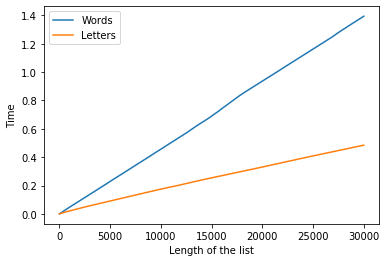

In [30]:
plt.plot([len(X[:i]) for i in range(len(X))] ,Y)
plt.plot([len(X_l[:i]) for i in range(len(X_l))] ,Y_l)
plt.legend(('Words', 'Letters'))
plt.xlabel("Length of the list")
plt.ylabel("Time")
plt.show()

## Question 3: Find similar wines!

In [9]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns

In [59]:
df = pd.read_csv("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/wine.data",header=None)

In [60]:
df_names = pd.read_table("/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW4/wine.names")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [61]:
df_names = ['class','alcohol','malic_acid','ash','alcalinity_of_ash',
            'magnesium','total phenols','flavanoids',
             'nonflavanoid phenols','proanthocyanins',
             'color_intensity','hue','ods_wines','proline']
d = dict(zip(df.columns,df_names))
df = df.rename(columns = d) 
target = df['class']
df.drop(columns = 'class',inplace = True)

In [120]:
# normalize the data frame because i want correct vectors
# also it will help to convergence k-means faster
normalized_df = (df - df.mean()) / df.std() 

In [286]:
#Euclidean distance
def euc(x,y):
    return np.sqrt(((x-y)**2).sum())
    

#Eucludean distance matrix    
def dist(X):
    m = X.shape[0]
    D = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            D[i,j] = euc(X[i], X[j])       
    return D

In [287]:
# k-means
class k_meansClustering:
    def __init__(self, data, k, max_iter = 16):
        self.max_iter = max_iter
        self.data = data
        self.k = k
        self.ind_init_centr = data.iloc[random.sample(list(data.index),self.k)] # create the initial centres
    def k_distance(self,y_k): # count the distance
        dist = {}
        for ind,x in self.data.iterrows():
            dist[ind] = [euc(np.array(x),y) for y in np.array(y_k)]
        return dist
    def class_belong(self,centers): # the input is current centers and the output the dict of points and classes
        class_belong = defaultdict(list)
        D = self.k_distance(centers) # find the dicstances
        for key,value in D.items():
            class_belong[np.argmin(value)].append(key) # find the smallest distances 
        return dict(sorted(class_belong.items())) # i need to return sorted dict to be sure than the classes will not mix
    def centr_identify(self,centers): # the find the geometry cents of the class
        class_belong = self.class_belong(centers)
        centers = []
        for cls,ind_vectors in class_belong.items():
            centers.append(self.data.iloc[ind_vectors].sum()/len(ind_vectors)) # summ all vectors of the class and divide it over number of the elements in the class
        return centers
    # the main function which do the clasterization
    def clusterization(self):
        count_iter = 0 # counter
        centers = self.centr_identify(self.ind_init_centr) # initial classes
        cost_last_iteration = self.costFunction(self.class_belong(centers),centers) # cost 
        while count_iter < self.max_iter: # repeat till the max itterations
            cost_last_iteration = self.costFunction(self.class_belong(centers),centers)
            centers = self.centr_identify(centers) # the main function it takes the old centers find its geom centers and return the new centers
            count_iter += 1
            if abs(self.costFunction(self.class_belong(centers),centers) - cost_last_iteration  ) < 0.00000000001: # if the cost doesnt change stop the itterations
                break
        print("Number of itterations:", count_iter)
        return self.class_belong(centers),centers
    def costFunction(self,class_belong,centers): # cost function
        D = self.k_distance(centers)
        cost = defaultdict(float)
        for key,value in D.items():
            cost[np.argmin(value)] += np.min(value)
        return sum(cost.values()) # count the sums of dist to the center of the classes 


In [291]:
loss_cost = []
for k in range(2,10):
    k_means = k_meansClustering(normalized_df,k)
    D,C = k_means.clusterization()
    loss_cost.append(k_means.costFunction(D,C))

Number of itteration: 7
Number of itteration: 6
Number of itteration: 6
Number of itteration: 10
Number of itteration: 7
Number of itteration: 7
Number of itteration: 4
Number of itteration: 12


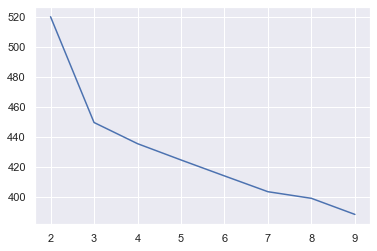

In [292]:
plt.plot(range(2,10),loss_cost)

In [293]:
k_means = k_meansClustering(normalized_df,3)
D,C = k_means.clusterization()

Number of itteration: 6


In [7]:
import numpy as np
from sklearn.manifold import TSNE
X = normalized_df
X_embedded = TSNE(n_components = 2).fit_transform(X)
X_embedded.shape

(178, 2)

In [295]:
X_embedded = pd.DataFrame(X_embedded)
X_embedded["Class"] = ""
for clas,ind in D.items():
    X_embedded["Class"][ind] = clas
X_embedded["Target"] = target - 1
X_embedded = X_embedded.rename(columns = {0:"x",1:"y"})

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### k-mean result

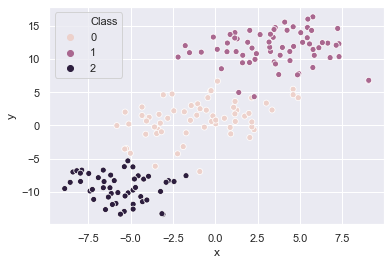

In [296]:
ax = sns.scatterplot(x = "x", y = "y", hue = "Class", data = X_embedded)

### Real clusterization

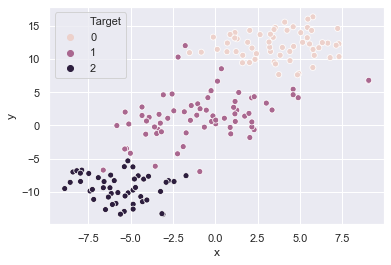

In [297]:
ax = sns.scatterplot(x = "x", y = "y", hue = "Target", data = X_embedded)

### Distribution analysis

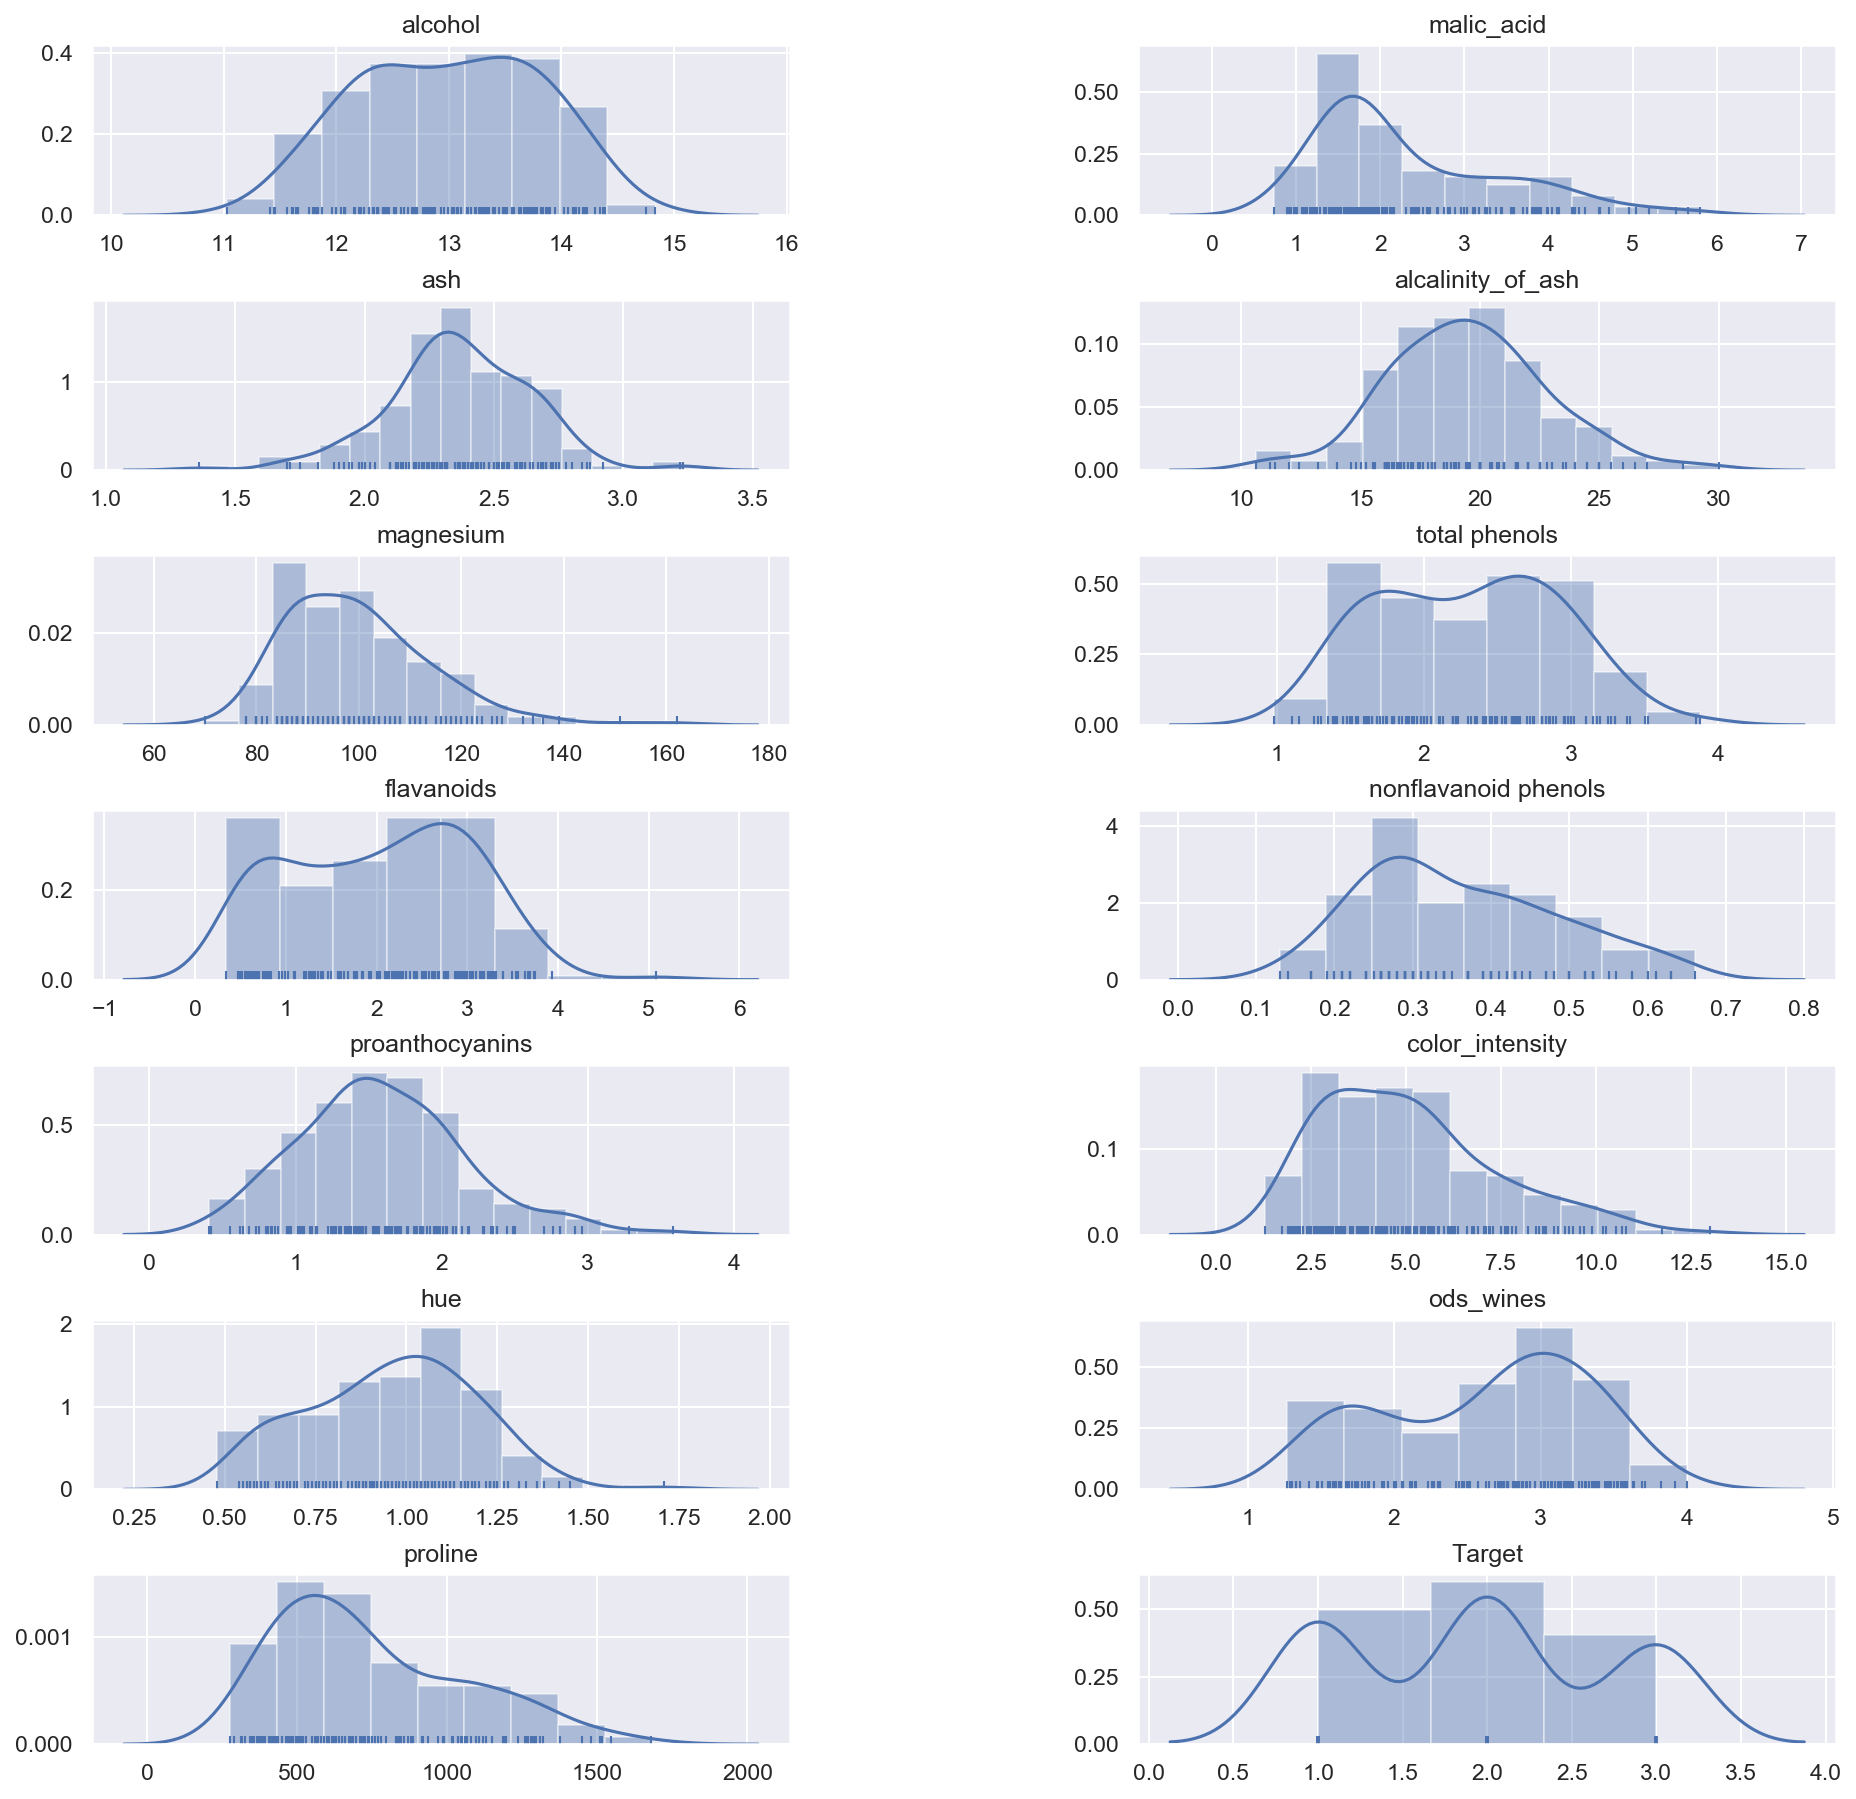

In [114]:
sns.set(color_codes=True)
fig, axs = plt.subplots(ncols=2,nrows = 7,figsize=(15,15),dpi=150) # create a figure
plt.subplots_adjust(hspace = 0.5, wspace = 0.5) # manipulate the space between plots in figure
n_row = 1
n_col = 1
# plot the histogramms
for i in df.columns:
    sns.distplot(list(df[i]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    if n_col % 2 == 0:
        n_row += 1
        n_col = 1
    else:
        n_col += 1
#fig.legend(labels = df.columns)

**As we can see the is a few hists which are really interestion. For example 'total_phenols' and "alcohol" has two maximums and also ods_wines which means that this features is preatty important because there is a big difference in dataset which can help us to understand the classes better. Also 'malic_acid', 'proanthocyanins', 'color_intensity' and 'proline' has very interesting histogramms because there are wide-spread**

### For more deep understanding let's look at the scatter plot of the 'proline' and  'malic_acid':

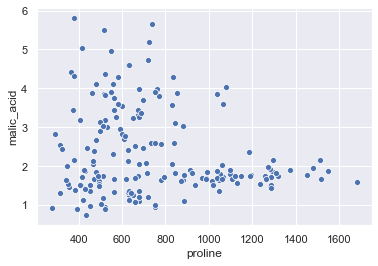

In [126]:
sns.scatterplot(x = 'proline', y = 'malic_acid',data = df)

Now we can see that our features has high variability and also i can assume that there is at least 2 or 3 classes because of wide spread of "proline" and spread of the "malic_acid"

### Now lets look at the histograms with the collours of classes

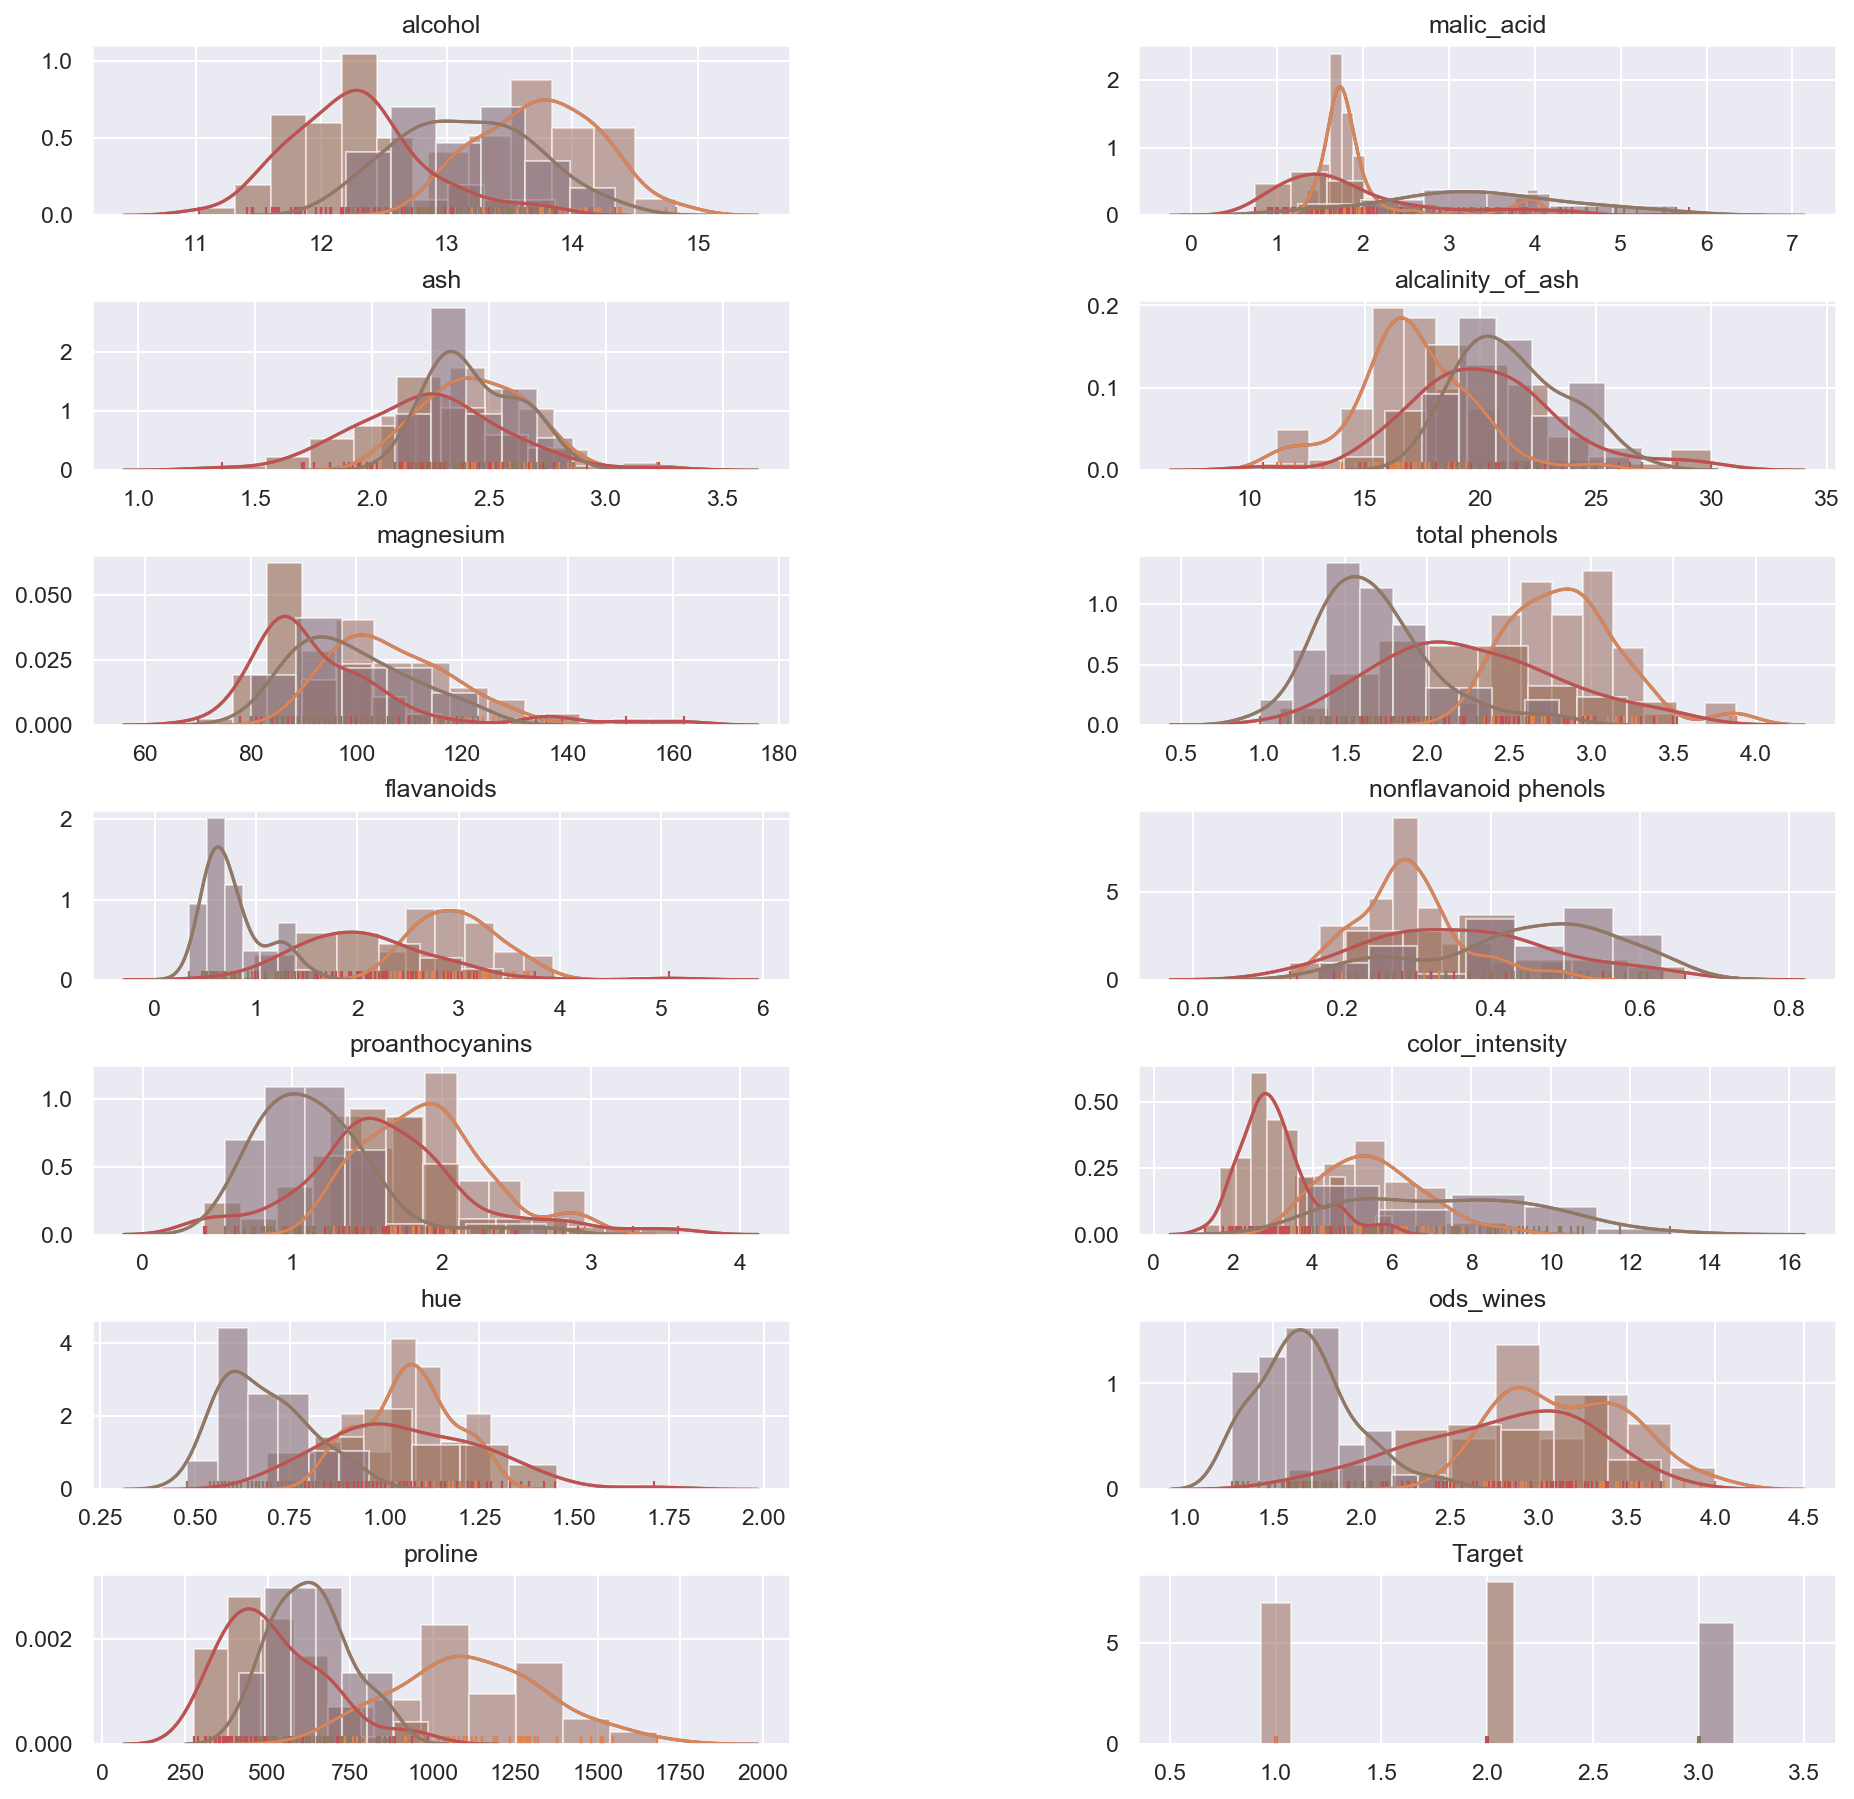

In [127]:
sns.set(color_codes=True)

fig, axs = plt.subplots(ncols=2,nrows = 7,figsize=(15,15),dpi=150) # create a figure
plt.subplots_adjust(hspace = 0.5, wspace = 0.5) # manipulate the space between plots in figure
n_row = 1
n_col = 1
# plot the histogramms
for i in df.columns:
    sns.distplot(list(df[i][df["Target"] == 1]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    sns.distplot(list(df[i][df["Target"] == 1]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    sns.distplot(list(df[i][df["Target"] == 2]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    sns.distplot(list(df[i][df["Target"] == 2]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    sns.distplot(list(df[i][df["Target"] == 3]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    sns.distplot(list(df[i][df["Target"] == 3]), ax=axs[n_row - 1][n_col - 1],kde = True , rug = True).set_title(i)
    if n_col % 2 == 0:
        n_row += 1
        n_col = 1
    else:
        n_col += 1

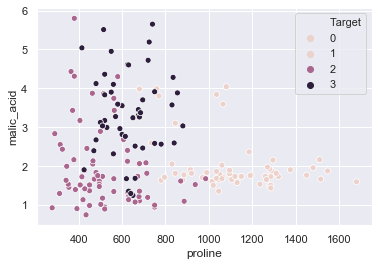

In [128]:
sns.scatterplot(x = 'proline', y = 'malic_acid',hue = 'Target',data = df)

### Now lets take a look on the scatter plot of the all features by pairs
#### Note: I can make scatter plot for all data set but there it will be really small plot because there will be the matrix 14x14 so i decided to split dataset because it will in two half. 
###### Note: Ofcourse we will lose some plots but steal we will have enough plots to understand the data

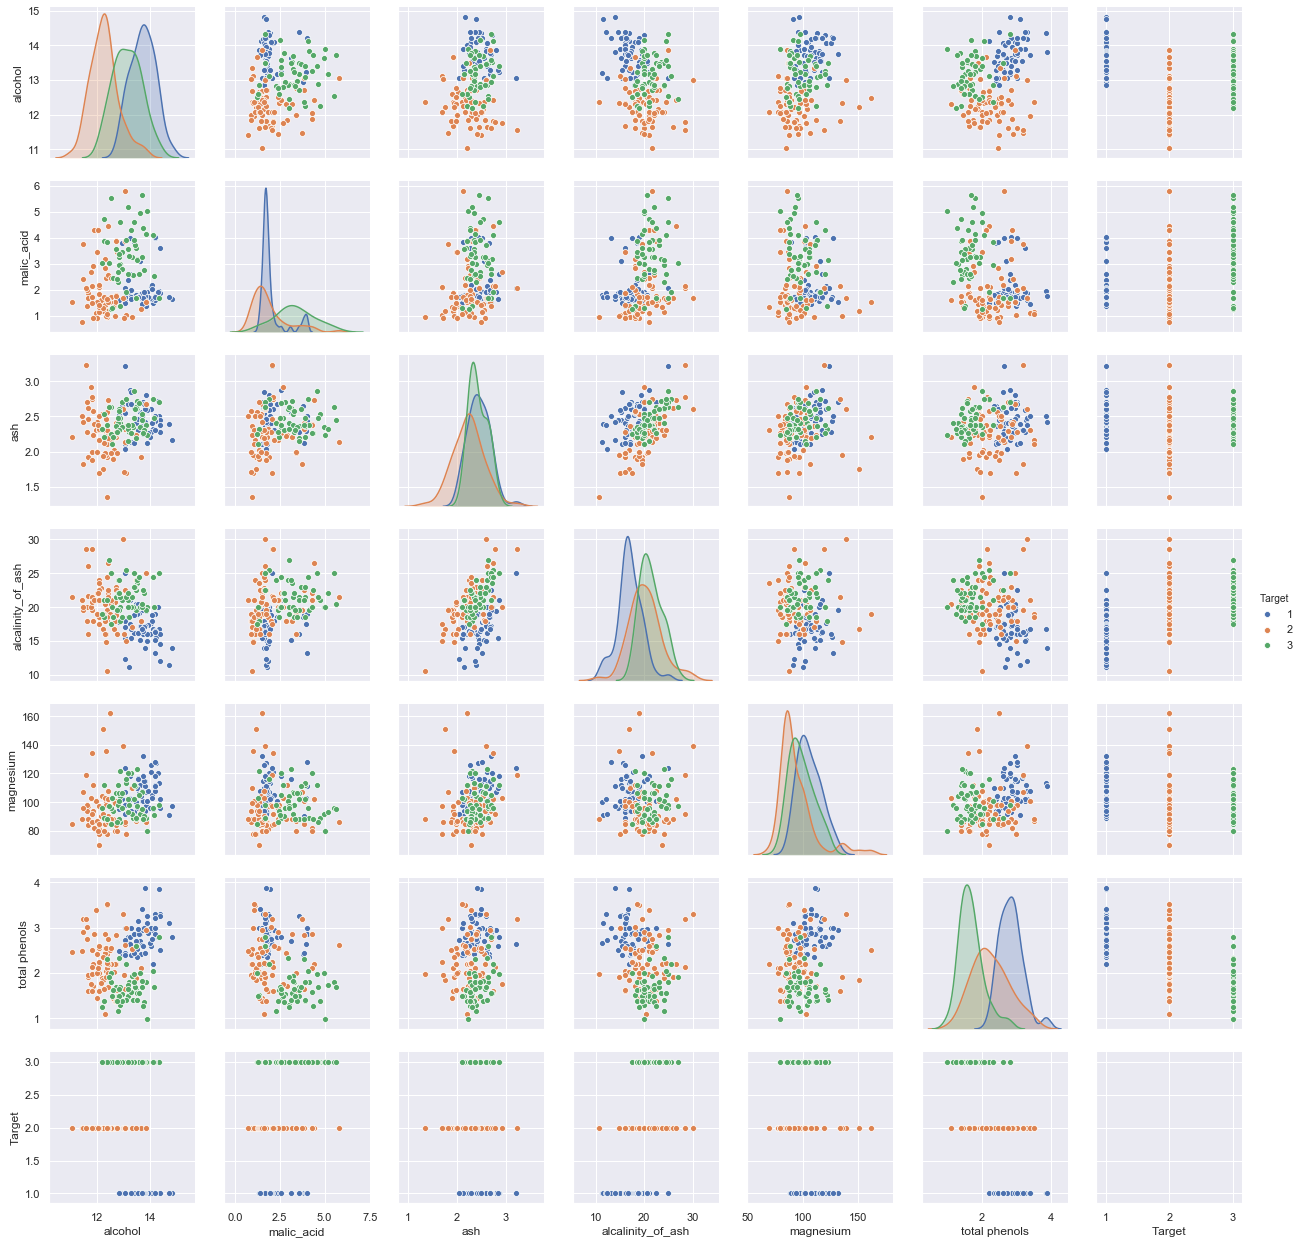

In [63]:
df["Target"] = target
sns.pairplot(df[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total phenols','Target']],hue = "Target")

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total phenols', 'flavanoids', 'nonflavanoid phenols',
       'proanthocyanins', 'color_intensity', 'hue', 'ods_wines', 'proline',
       'Target'],
      dtype='object')

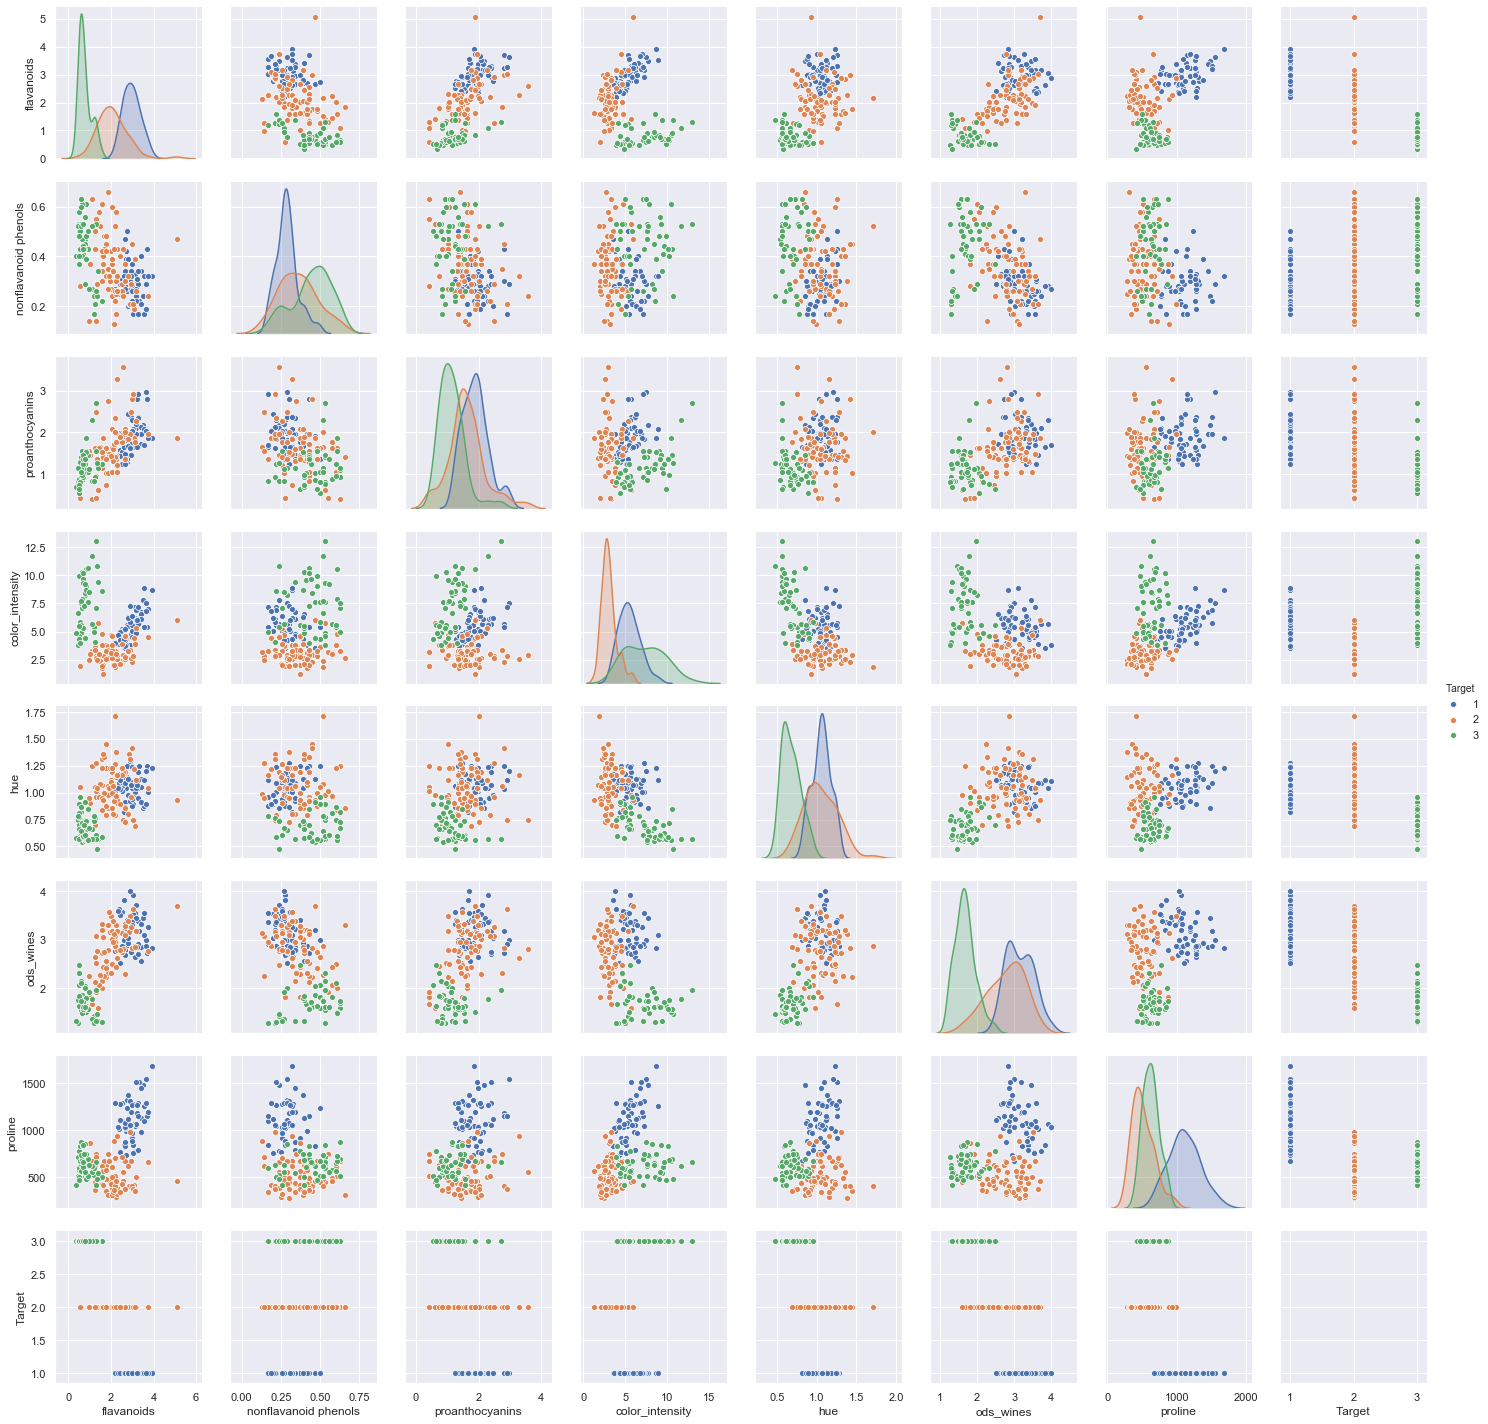

In [21]:
sns.pairplot(df[['flavanoids', 'nonflavanoid phenols',
       'proanthocyanins', 'color_intensity', 'hue', 'ods_wines', 'proline',
       'Target']],hue = "Target")
df.columns

**It is easy to see can see with the collors points that a lot of plots have quite good distinguish of the clusters. I mean that the points which belongs to the different classes has different meand and also different variance but still all clusters close to each other what is not suprising because there are all the wines and they have some features which is in common**

## Question 3: Bonus

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn.manifold import TSNE
wine = pd.read_csv('C:/Users/mechket/Desktop/HW4_ADM/wine.data.csv', header=None)

In [2]:
wine_names = ['class','alcohol','malic_acid','ash','alcalinity_of_ash',
            'magnesium','total phenols','flavanoids',
             'nonflavanoid phenols','proanthocyanins',
             'color_intensity','hue','ods_wines','proline']

In [3]:
d = dict(zip(wine.columns,wine_names))
wine = wine.rename(columns = d) 
target = wine['class']
wine.drop(columns = 'class',inplace = True)

In [4]:
wine = (wine - wine.mean()) / wine.std()

In [5]:
# Euclidean Distance function
def euclidian_dist(pt1,pt2) :
    return round(math.sqrt(sum((pt1-pt2)**2)),2)

In [37]:
#Mapping function
def mapping(points,centroids,K):
    mapper=[]
    for pt in points:
        mini=euclidian_dist(pt,centroids.iloc[0,:])
        classe=0
        for k in range(K):
            if mini>euclidian_dist(pt,centroids.iloc[k,:]):
                mini=euclidian_dist(pt,centroids.iloc[k,:])
                classe=k
        mapper.append((classe,pt))
    return(mapper)
#Reducing function
def reducing(data,centroids,mapper,K):
    for k in range(K):
            count=0
            sum_pt=np.zeros(data.shape[1])
            for x in range(len(mapper)):
                if mapper[x][0]==k:
                    count+=1
                    sum_pt+=mapper[x][1]
            centroids.iloc[k,:]=sum_pt/count
    return(centroids)
            
def kmeansMPR(data,K):
    #Save the dataset rows as arrays (vectors)
    points=[]
    for i in range (data.shape[0]):
        points.append(np.array(data.iloc[i,:].values))
        
    #Initialize centroids
    centroids=data.iloc[random.sample(list(data.index),K)]
    #Number of iterations
    it=10
    for i in range(it):
        #Map
        mapper=mapping(points,centroids,K)
        
        #Reduce
        centroids=reducing(wine,centroids,mapper,K)
        
        X_embedded = TSNE(n_components = 2).fit_transform(data)
        X_embedded= pd.DataFrame(X_embedded)
        colors = ['r','y', 'g', 'purple', 'c', 'm']
    fig, ax = plt.subplots()
    for k in range(K):
        points_clust_x = np.array([X_embedded.iloc[r,0] for r in range(X_embedded.shape[0]) if mapper[r][0] == k])
        points_clust_y = np.array([X_embedded.iloc[r,1] for r in range(X_embedded.shape[0]) if mapper[r][0] == k])
        plt.scatter(points_clust_x,points_clust_y, s=12, c=colors[k])
    
    return   
    

C:\Users\mechket\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mechket\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mechket\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mechket\Anaconda3\lib\site-packages\ipyk

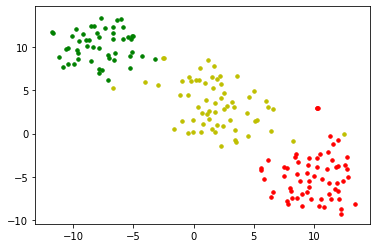

In [38]:
kmeansMPR(wine,3)

## The 4th question 

Initialization of the centroids can either damage our clustering or allow us to get a good clustering.
If we choose all our centroids with unbalance (that means we put most of the initialized centroids in one cluster)
we will not be able probably to have the expected final clusters. In other words, the program won't be able to move
the centroids to the other clusters, and this result is due to the lack of the overlap between the different clusters.
So, if the initialization of the centroids is not done in a balanced way, even the multiple iterations of the k_means will not be able to improve the positions of the centroids.


The example
We took our initial centroids only in one cluster. That's why the points that were selected are:
  **Initial centroid 1= data.iloc[19,:]. this point is located in  (6.733279;-10.424692)**
  **Initial centroid 2= data.iloc[18,:]. this point is located in  (12.714202;-10.475096)**
  **Initial centroid 3= data.iloc[39,:]. this point is located in  (6.626827;-10.962433)**

In [33]:
def kmeansMPR(data,K):
    #Save the dataset rows as arrays (vectors)
    points=[]
    for i in range (data.shape[0]):
        points.append(np.array(data.iloc[i,:].values))
        
    #Initialize centroids
    centroids=data.iloc[[19,18,39],:]
    #Number of iterations
    it=10
    for i in range(it):
        mapper=[]
        for pt in points:
            mini=euclidian_dist(pt,centroids.iloc[0,:])
            classe=0
            for k in range(K):
                if mini>euclidian_dist(pt,centroids.iloc[k,:]):
                    mini=euclidian_dist(pt,centroids.iloc[k,:])
                    classe=k
            mapper.append((classe,pt))
    #Reduce
        for k in range(K):
            count=0
            sum_pt=np.zeros(data.shape[1])
            for x in range(len(mapper)):
                if mapper[x][0]==k:
                    count+=1
                    sum_pt+=mapper[x][1]
            centroids.iloc[k,:]=sum_pt/count
        X_embedded = TSNE(n_components = 2).fit_transform(data)
        X_embedded= pd.DataFrame(X_embedded)
        colors = ['r','y', 'g', 'purple', 'c', 'm']
    fig, ax = plt.subplots()
    for k in range(K):
        points_clust_x = np.array([X_embedded.iloc[r,0] for r in range(X_embedded.shape[0]) if mapper[r][0] == k])
        points_clust_y = np.array([X_embedded.iloc[r,1] for r in range(X_embedded.shape[0]) if mapper[r][0] == k])
        plt.scatter(points_clust_x,points_clust_y, s=12, c=colors[k])
    print(X_embedded.loc[19,:],X_embedded.loc[18,:],X_embedded.loc[39,:])
    return   
    

C:\Users\mechket\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mechket\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mechket\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mechket\Anaconda3\lib\site-packages\ipyk

0     6.733279
1   -10.424692
Name: 19, dtype: float32 0    12.714202
1   -10.475096
Name: 18, dtype: float32 0     6.626827
1   -10.962433
Name: 39, dtype: float32


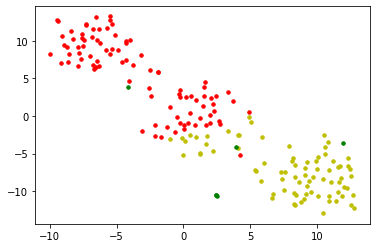

In [34]:
kmeansMPR(wine,3)
#As it was predicted, the kmeans method doesn't work correctly.
#In fact, it fails to provide us with the three clusters we want because of the bad choice of the initial centroids. 

As it was predicted, the kmeans method doesn't work correctly.
In fact, it fails to provide us with the three clusters we want because of the bad choice of the initial centroids. 